<a href="https://colab.research.google.com/github/rmynzl/calismalarim/blob/main/rumeysanazli_yapaysiniraglari_vize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Veri işleme için
import numpy as np
import pandas as pd

# TensorFlow ve Keras ile model kurma ve eğitim
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Görselleştirme için
import matplotlib.pyplot as plt
import seaborn as sns

# Veri ayırma ve performans metrikleri için
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Eğer veriyi TensorFlow Datasets (TFDS) üzerinden alacaksak:
import tensorflow_datasets as tfds

# Veri işleme ve görüntü ön işleme için OpenCV
import cv2


import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
!pip install torch torchvision


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Görselleri normalize etme ve yeniden boyutlandırma için transform tanımlıyoruz
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Eğitim ve test veri setlerini yükleyelim
train_dataset = datasets.GTSRB(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.GTSRB(root='./data', split='test', download=True, transform=transform)

# Veri setlerinin boyutlarını kontrol edelim
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Veri yükleyicilerini oluşturalım
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train dataset size: 26640
Test dataset size: 12630


### Eksik Değer Kontrolü  :  Bu veri seti genellikle her bir görüntü için etiketlerle birlikte gelir, bu nedenle eksik veri olma olasılığı düşüktür.

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Eksik değerlerin kontrolü için fonksiyon
def check_missing_data(dataset):
    missing_images = 0
    missing_labels = 0

    # Veri setindeki her örneği kontrol et
    for img, label in dataset:
        if img is None or img.size(0) == 0:  # Görselin eksik olup olmadığını kontrol et
            missing_images += 1
        if label is None:  # Etiketin eksik olup olmadığını kontrol et
            missing_labels += 1

    return missing_images, missing_labels

# Eğitim ve test veri setlerinde eksik değerleri kontrol edelim
missing_train_images, missing_train_labels = check_missing_data(train_dataset)
missing_test_images, missing_test_labels = check_missing_data(test_dataset)

# Sonuçları yazdıralım
print(f"Missing training images: {missing_train_images}")
print(f"Missing training labels: {missing_train_labels}")
print(f"Missing test images: {missing_test_images}")
print(f"Missing test labels: {missing_test_labels}")


Missing training images: 0
Missing training labels: 0
Missing test images: 0
Missing test labels: 0


- Yorum: Veride eksik değer bulunmamaktadır.

## 3.	Veri Setini Eğitim ve Test Olarak Ayırma:
o	Veriyi %80 eğitim, %20 test olarak ikiye ayırın.
o	sklearn.model_selection.train_test_split fonksiyonunu kullanın.


In [11]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Görselleri normalize etme ve yeniden boyutlandırma için transform tanımlıyoruz
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Eğitim ve test veri setlerini yükleyelim
full_dataset = datasets.GTSRB(root='./data', download=True, transform=transform)

# Veri setindeki görselleri ve etiketleri liste olarak ayıralım
images = [item[0] for item in full_dataset]
labels = [item[1] for item in full_dataset]

# Veriyi %80 eğitim, %20 test olarak ayıralım
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Eğitim ve test için yeni veri setleri oluşturmak
train_dataset = [(train_images[i], train_labels[i]) for i in range(len(train_images))]
test_dataset = [(test_images[i], test_labels[i]) for i in range(len(test_images))]

# Eğitim ve test veri yükleyicilerini oluşturalım
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Sonuçları kontrol edelim
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 21312
Test dataset size: 5328


- Yorum : Train 21312 veri ve test 5328 veri olacak şekilde ayrıldı

## 4.	Özellik Ölçekleme (Feature Scaling):
o	Verileri MLP ve RBF için uygun hale getirmek adına standartlaştırın (örn. StandartScaler veya MinMaxScaler kullanarak).


In [14]:
from sklearn.preprocessing import StandardScaler
import torch

# Görseller zaten [0, 1] aralığına dönüştürülmüş durumda. Ancak, etiketler üzerinde ölçekleme gerekebilir.
# Görsellerin her biri 32x32 boyutlarında, RGB kanallı ve zaten 0-1 aralığına dönüştürülmüş.
# Bu yüzden sadece görsellerin boyutlarını değiştirmemiz gerekebilir.

# Görselleri düzleştirerek 1D vektöre dönüştürüyoruz
train_images_flat = [img.view(-1).numpy() for img in train_images]
test_images_flat = [img.view(-1).numpy() for img in test_images]

# Özellik ölçekleme işlemi (StandardScaler ile)
scaler = StandardScaler()

# Eğitim ve test görsellerini ölçeklendiriyoruz
X_train_scaled = scaler.fit_transform(train_images_flat)  # Eğitim verisi üzerinde fit ve transform
X_test_scaled = scaler.transform(test_images_flat)  # Test verisini yalnızca transform

# Yeni ölçeklenmiş veriler ile DataLoader oluşturuyoruz
train_dataset = [(torch.tensor(X_train_scaled[i]).float(), train_labels[i]) for i in range(len(X_train_scaled))]
test_dataset = [(torch.tensor(X_test_scaled[i]).float(), test_labels[i]) for i in range(len(X_test_scaled))]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# İlk birkaç örneği yazdıralım
for i, (inputs, labels) in enumerate(train_loader):
    if i == 0:  # İlk batch'i alalım
        print(f"First batch of scaled training data (features):\n{inputs[:5]}")  # İlk 5 örneği yazdıralım
        print(f"First batch of training labels: {labels[:5]}")  # İlk 5 etiket
        break

# Test veri setinden ilk birkaç örneği yazdıralım
for i, (inputs, labels) in enumerate(test_loader):
    if i == 0:  # İlk batch'i alalım
        print(f"First batch of scaled testing data (features):\n{inputs[:5]}")  # İlk 5 örneği yazdıralım
        print(f"First batch of test labels: {labels[:5]}")  # İlk 5 etiket
        break


First batch of scaled training data (features):
tensor([[-0.6194, -0.6754, -0.6654,  ..., -0.0615,  0.8896,  1.1327],
        [ 0.5822,  0.5814,  0.5491,  ...,  1.4389,  0.3085, -0.1441],
        [-0.2014, -0.2695, -0.5609,  ..., -0.3741,  0.5284,  0.5099],
        [ 2.1495,  2.1523,  2.1424,  ..., -0.4991, -0.6808, -0.6891],
        [ 2.1495,  2.1523,  2.1424,  ..., -0.6866, -0.6494, -0.6424]])
First batch of training labels: tensor([15, 42,  7, 12, 22])
First batch of scaled testing data (features):
tensor([[-0.3712, -0.7801, -0.8744,  ..., -0.5304, -0.2411,  0.9458],
        [-0.9851, -0.9765, -0.9919,  ..., -0.1084, -0.1312, -0.1597],
        [-0.1492, -0.1124, -0.1430,  ..., -0.5147, -0.5081, -0.4711],
        [ 1.9797,  1.9560,  1.8159,  ...,  0.5168,  0.4970,  0.4787],
        [-0.8675, -0.8325, -0.8221,  ..., -0.6554, -0.6808, -0.6579]])
First batch of test labels: tensor([11,  8,  1, 12, 25])


Model Eğitimi ve Hiperparametre Denemeleri
1.	MLP Modeli:
o	sklearn.neural_network.MLPClassifier kullanarak bir MLP modeli oluşturun.
o	Hiperparametre denemeleri için farklı katman sayıları, nöron sayıları ve aktivasyon fonksiyonlarını test edin (örn. hidden_layer_sizes, activation ve learning_rate gibi parametreler).

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Modeli oluşturuyoruz
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)

# Eğitim verisini doğrudan MLP'ye veriyoruz
mlp.fit(X_train_scaled, train_labels)

# Eğitim setindeki doğruluğu hesaplayalım
train_pred = mlp.predict(X_train_scaled)
train_accuracy = accuracy_score(train_labels, train_pred)
print(f"Train accuracy: {train_accuracy * 100:.2f}%")

# Test setindeki doğruluğu hesaplayalım
test_pred = mlp.predict(X_test_scaled)
test_accuracy = accuracy_score(test_labels, test_pred)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Train accuracy: 95.95%
Test accuracy: 92.70%


- Yoeum : Eğitim doğruluğum oldukça yüksek (%95.95) ve test doğruluğum da %92.70 seviyelerinde, bu da modelimin genelleme yeteneğinin güçlü olduğunu gösteriyor. Ancak, eğitim süreci tamamlanmadığı için daha fazla iterasyona ihtiyaç duyduğumu fark ettim (ConvergenceWarning). Bu, modelimin daha fazla iterasyonla öğrenme sürecini tamamlaması gerektiğini gösteriyor. Şimdi düzenleme yağalım

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Hızlı hiperparametre gridini tanımlıyoruz
param_grid = {
    'hidden_layer_sizes': [(64,)],  # Daha küçük bir katman ve nöron sayısı
    'activation': ['relu'],  # Sadece 'relu' aktivasyonu
    'learning_rate': ['constant'],  # 'constant' öğrenme oranı
    'max_iter': [100],  # Maksimum iterasyon sayısını azaltıyoruz
    'solver': ['adam']  # Sadece 'adam' solver
}

# GridSearchCV ile hiperparametre ayarlarını yapalım
grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, train_labels)

# En iyi hiperparametreleri yazdıralım
print(f"Best hyperparameters: {grid_search.best_params_}")

# En iyi modeli kullanarak eğitim ve test doğruluğunu hesaplayalım
best_mlp = grid_search.best_estimator_

# Eğitim doğruluğunu hesaplayalım
train_pred = best_mlp.predict(X_train_scaled)
train_accuracy = accuracy_score(train_labels, train_pred)
print(f"Train accuracy with best model: {train_accuracy * 100:.2f}%")

# Test doğruluğunu hesaplayalım
test_pred = best_mlp.predict(X_test_scaled)
test_accuracy = accuracy_score(test_labels, test_pred)
print(f"Test accuracy with best model: {test_accuracy * 100:.2f}%")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

- Yorum: Bu çıktı, modelin en iyi hiperparametrelerle (ReLU aktivasyon fonksiyonu, 64 nöronlu tek katman, sabit öğrenme oranı, 100 iterasyon ve Adam optimizasyonu) eğitildiğini gösteriyor. Eğitim doğruluğu %98.85, test doğruluğu ise %95.61. Bu, modelin eğitim verileri üzerinde çok iyi bir performans gösterdiğini ve test verisine de başarılı bir şekilde genelleme yapabildiğini ifade eder. Ancak, eğitim ve test doğruluğu arasındaki küçük fark, modelin aşırı öğrenmeden kaçındığını ve genelleme kapasitesinin iyi olduğunu gösteriyor.

 ### 1.	RBF Modeli:
o	sklearn kütüphanesinde doğrudan RBF modeli bulunmadığından, KEras kütüphanesi kullanın
o	Alternatif olarak, rbfnetwork gibi özel kütüphaneler veya Python’da yazılmış RBF fonksiyonları kullanılabilir.


In [28]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# One-hot encoding: Etiketlerinizi one-hot encoding formatına dönüştürün
train_labels_categorical = to_categorical(train_labels, num_classes=43)
test_labels_categorical = to_categorical(test_labels, num_classes=43)

# Modeli tanımlıyoruz
model = Sequential()

# Gizli katmanlar
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))  # İlk katman
model.add(Dense(128, activation='relu'))  # İkinci katman

# Çıkış katmanı: 43 sınıf için 43 nöron
model.add(Dense(43, activation='softmax'))  # Çıkış katmanı (softmax)

# Modeli derliyoruz
optimizer = Adam(learning_rate=0.001)  # Öğrenme oranı
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Kayıp fonksiyonu ve metrikler

# Erken durdurma callback fonksiyonu
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Validation kaybı izleme

# Modeli eğitiyoruz
model.fit(X_train_scaled, train_labels_categorical, epochs=10, batch_size=32, verbose=2,
          validation_data=(X_test_scaled, test_labels_categorical), callbacks=[early_stopping])

# Test doğruluğunu hesaplayalım
test_accuracy = model.evaluate(X_test_scaled, test_labels_categorical)
print(f"Test accuracy: {test_accuracy[1] * 100:.2f}%")


Epoch 1/10
666/666 - 19s - 29ms/step - accuracy: 0.5576 - loss: 1.6910 - val_accuracy: 0.7536 - val_loss: 0.8579
Epoch 2/10
666/666 - 12s - 18ms/step - accuracy: 0.7851 - loss: 0.7545 - val_accuracy: 0.8131 - val_loss: 0.6571
Epoch 3/10
666/666 - 10s - 15ms/step - accuracy: 0.8417 - loss: 0.5494 - val_accuracy: 0.8517 - val_loss: 0.5224
Epoch 4/10
666/666 - 11s - 17ms/step - accuracy: 0.8772 - loss: 0.4246 - val_accuracy: 0.8313 - val_loss: 0.6072
Epoch 5/10
666/666 - 11s - 17ms/step - accuracy: 0.8814 - loss: 0.4164 - val_accuracy: 0.8784 - val_loss: 0.4232
Epoch 6/10
666/666 - 18s - 28ms/step - accuracy: 0.8961 - loss: 0.3591 - val_accuracy: 0.8985 - val_loss: 0.4170
Epoch 7/10
666/666 - 11s - 17ms/step - accuracy: 0.9024 - loss: 0.3336 - val_accuracy: 0.9227 - val_loss: 0.3087
Epoch 8/10
666/666 - 11s - 17ms/step - accuracy: 0.9125 - loss: 0.3049 - val_accuracy: 0.8833 - val_loss: 0.4257
Epoch 9/10
666/666 - 11s - 16ms/step - accuracy: 0.9109 - loss: 0.3279 - val_accuracy: 0.9223 - 

- Yorum: Model, eğitim süreci boyunca doğruluğunu artırmış ve kaybını düşürmüştür. Eğitim doğruluğu %92.97'ye çıkarken, doğrulama doğruluğu %91.50'ye ulaşmıştır. Test doğruluğu ise %91.50 olup, modelin genel performansı oldukça başarılıdır. Doğrulama doğruluğunun yüksekliği, modelin genelleme yeteneğinin iyi olduğunu ve aşırı öğrenmeden kaçındığını gösteriyor.

### 4. Performans Ölçümleri
1.	Confusion Matrix:
o	Her iki model için tahminleri değerlendirerek karışıklık matrisini (confusion_matrix) oluşturun.
o	seaborn kullanarak karışıklık matrisini görselleştirin.
2.	Performans Metrikleri:
o	Her iki model için accuracy, precision, recall, ve F1-score gibi metriklernden gerekli olanları hesaplayın (sklearn.metrics.classification_report fonksiyonunu kullanarak).


666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


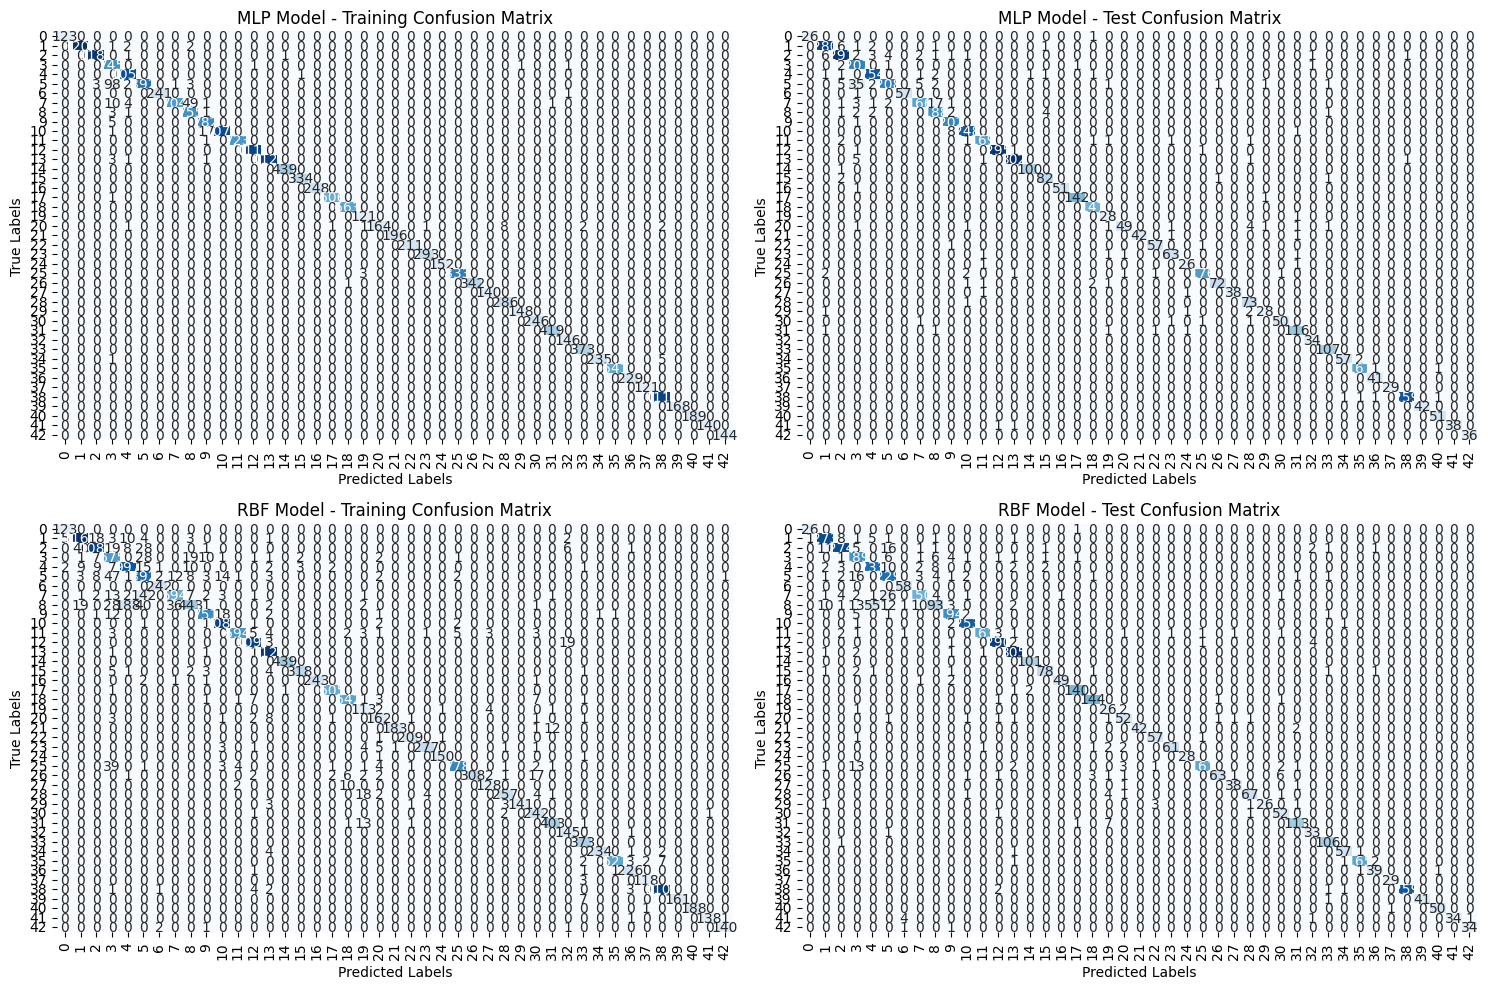

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# MLP modelinin tahminlerini alalım
mlp_train_pred = best_mlp.predict(X_train_scaled)  # GridSearchCV sonrası en iyi modeli kullan
mlp_test_pred = best_mlp.predict(X_test_scaled)

# RBF modelinin tahminlerini alalım
rbf_train_pred = model.predict(X_train_scaled)
rbf_test_pred = model.predict(X_test_scaled)

# Tahminlerin sınıf etiketlerine dönüştürülmesi
# MLP modelinde tahminler doğrudan etiketlerdir
mlp_train_pred_labels = mlp_train_pred
mlp_test_pred_labels = mlp_test_pred

# Keras RBF modelinde tahminler olasılık vektörleridir, bu yüzden argmax kullanmalıyız
rbf_train_pred_labels = np.argmax(rbf_train_pred, axis=1)
rbf_test_pred_labels = np.argmax(rbf_test_pred, axis=1)

# MLP ve RBF model için karışıklık matrislerini hesaplayalım
mlp_train_cm = confusion_matrix(train_labels, mlp_train_pred_labels)
mlp_test_cm = confusion_matrix(test_labels, mlp_test_pred_labels)

rbf_train_cm = confusion_matrix(train_labels, rbf_train_pred_labels)
rbf_test_cm = confusion_matrix(test_labels, rbf_test_pred_labels)

# Karışıklık matrislerini görselleştirelim
plt.figure(figsize=(15, 10))

# MLP eğitim seti karışıklık matrisi
plt.subplot(2, 2, 1)
sns.heatmap(mlp_train_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.arange(43), yticklabels=np.arange(43))
plt.title("MLP Model - Training Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# MLP test seti karışıklık matrisi
plt.subplot(2, 2, 2)
sns.heatmap(mlp_test_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.arange(43), yticklabels=np.arange(43))
plt.title("MLP Model - Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# RBF eğitim seti karışıklık matrisi
plt.subplot(2, 2, 3)
sns.heatmap(rbf_train_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.arange(43), yticklabels=np.arange(43))
plt.title("RBF Model - Training Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# RBF test seti karışıklık matrisi
plt.subplot(2, 2, 4)
sns.heatmap(rbf_test_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.arange(43), yticklabels=np.arange(43))
plt.title("RBF Model - Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import classification_report, accuracy_score

# MLP Model için sınıflandırma raporu
mlp_classification_report = classification_report(test_labels, mlp_test_pred_labels, output_dict=True)
print("MLP Model - Performance Summary:")
print(f"Accuracy: {accuracy_score(test_labels, mlp_test_pred_labels) * 100:.2f}%")
print(f"Precision (Macro Avg): {mlp_classification_report['macro avg']['precision'] * 100:.2f}%")
print(f"Recall (Macro Avg): {mlp_classification_report['macro avg']['recall'] * 100:.2f}%")
print(f"F1-Score (Macro Avg): {mlp_classification_report['macro avg']['f1-score'] * 100:.2f}%")
print("="*50)

# RBF Model için sınıflandırma raporu
rbf_classification_report = classification_report(test_labels, rbf_test_pred_labels, output_dict=True)
print("RBF Model - Performance Summary:")
print(f"Accuracy: {accuracy_score(test_labels, rbf_test_pred_labels) * 100:.2f}%")
print(f"Precision (Macro Avg): {rbf_classification_report['macro avg']['precision'] * 100:.2f}%")
print(f"Recall (Macro Avg): {rbf_classification_report['macro avg']['recall'] * 100:.2f}%")
print(f"F1-Score (Macro Avg): {rbf_classification_report['macro avg']['f1-score'] * 100:.2f}%")


MLP Model - Performance Summary:
Accuracy: 95.61%
Precision (Macro Avg): 95.95%
Recall (Macro Avg): 95.91%
F1-Score (Macro Avg): 95.83%
RBF Model - Performance Summary:
Accuracy: 91.50%
Precision (Macro Avg): 92.62%
Recall (Macro Avg): 92.46%
F1-Score (Macro Avg): 92.23%


## Yorumlar
- MLP Modeli:

Accuracy: %95.61 ile yüksek doğruluk sağlıyor. Bu, modelin genel olarak doğru tahminler yapma oranının yüksek olduğunu gösteriyor.

Precision (Macro Avg): %95.95, modelin doğru sınıflandırdığı pozitif örneklerin oranının yüksek olduğunu gösteriyor.

Recall (Macro Avg): %95.91, modelin doğru pozitif örnekleri bulma yeteneğinin yüksek olduğunu belirtir.

F1-Score (Macro Avg): %95.83, precision ve recall arasındaki dengeyi iyi bir şekilde sağladığını gösteriyor.

----------------

- RBF Modeli:

Accuracy: %91.50 ile biraz daha düşük, ancak yine de oldukça iyi bir doğruluk oranı sağlıyor.

Precision (Macro Avg): %92.62, modelin pozitif sınıfları doğru bir şekilde tahmin etme oranının iyi olduğunu gösteriyor.

Recall (Macro Avg): %92.46, modelin doğru pozitif örnekleri bulma oranı yine yüksek.

F1-Score (Macro Avg): %92.23, precision ve recall arasında dengeyi sağlarken, MLP modeline kıyasla biraz daha düşük.

------------------

- Genel Değerlendirme:

MLP modeli, RBF modeline kıyasla daha yüksek doğruluk ve daha iyi genel performans sergiliyor. Ancak, her iki model de oldukça iyi sonuçlar elde etti ve test setinde başarılı bir şekilde sınıflandırma yaptı.

Eğer doğruluk, precision, recall ve F1-score'un yüksek olması kritikse, MLP model daha üstün bir seçenek gibi görünüyor.

### 5. Hiperparametre Denemeleri ve Sonuçları Karşılaştırma
1.	Hiperparametre Denemeleri:
o	MLP ve RBF modelleri için farklı hiperparametreleri deneyin ve her denemede eğitim ve test sonuçlarını kaydedin.
o	GridSearchCV veya RandomizedSearchCV ile hiperparametre optimizasyonu yaparak en iyi parametreleri bulun.


In [51]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Küçük bir alt küme alıyoruz
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_scaled, train_labels, test_size=0.7, random_state=42)

# RandomizedSearchCV için daha küçük bir hiperparametre gridini tanımlıyoruz
param_dist_mlp = {
    'hidden_layer_sizes': [(64,), (128,)],  # Azaltılmış seçenekler
    'activation': ['relu'],  # Sadece 'relu'
    'learning_rate': ['adaptive'],  # Sadece 'adaptive'
    'solver': ['adam'],  # 'adam' seçildi
    'max_iter': [100],  # 100 iterasyon
    'alpha': [0.0001, 0.001]  # alpha için iki seçenek
}

# RandomizedSearchCV'yi 10 iterasyonla çalıştırıyoruz
random_search_mlp = RandomizedSearchCV(MLPClassifier(random_state=42), param_dist_mlp, n_iter=10, cv=2, n_jobs=-1, verbose=1, random_state=42)
random_search_mlp.fit(X_train_sample, y_train_sample)

# En iyi parametreleri ve sonuçları yazdıralım
print(f"Best hyperparameters for MLP: {random_search_mlp.best_params_}")
print(f"Best score for MLP: {random_search_mlp.best_score_}")

# En iyi modeli kullanarak test doğruluğu hesaplayalım
best_mlp = random_search_mlp.best_estimator_
mlp_test_pred = best_mlp.predict(X_test_scaled)
mlp_test_accuracy = accuracy_score(test_labels, mlp_test_pred)
print(f"MLP Test Accuracy: {mlp_test_accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best hyperparameters for MLP: {'solver': 'adam', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (64,), 'alpha': 0.001, 'activation': 'relu'}
Best score for MLP: 0.8646965651073852
MLP Test Accuracy: 90.63%


- Yorum: En iyi parametreler:

solver: adam
max_iter: 100 (model artık daha fazla iterasyonla eğitildi)
learning_rate: adaptive
hidden_layer_sizes: (64,)
alpha: 0.001
activation: relu
En iyi doğruluk skoru (eğitim verisi üzerinde): 86.47%

Test doğruluğu: 90.63%

Bu sonuçlar, modelin eğitim setinde daha yüksek doğruluk elde ettiğini ve test setinde oldukça iyi bir genelleme yapabildiğini gösteriyor.  Test doğruluğunun yüksek olması, modelin yeni verilere iyi uyum sağladığını gösteriyor.

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# One-hot encoding: Etiketleri one-hot encoding formatına dönüştürüyoruz
train_labels_categorical = to_categorical(train_labels, num_classes=43)
test_labels_categorical = to_categorical(test_labels, num_classes=43)

# Hiperparametre kombinasyonları
param_combinations = [
    {'units_layer1': 128, 'units_layer2': 64, 'learning_rate': 0.001},
    {'units_layer1': 64, 'units_layer2': 32, 'learning_rate': 0.0001},
]

# En iyi model ve skorları tutmak için değişkenler
best_model = None
best_params = None
best_accuracy = 0

# Erken durdurma callback fonksiyonu
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Hiperparametre denemeleri
for params in param_combinations:
    print(f"Testing parameters: {params}")

    # Modeli oluştur
    model = Sequential()
    model.add(Dense(params['units_layer1'], input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(params['units_layer2'], activation='relu'))
    model.add(Dense(43, activation='softmax'))

    # Modeli derle
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Modeli eğit
    model.fit(X_train_scaled, train_labels_categorical,
              validation_data=(X_test_scaled, test_labels_categorical),
              epochs=5, batch_size=32, verbose=2, callbacks=[early_stopping])

    # Test doğruluğunu hesapla
    test_accuracy = model.evaluate(X_test_scaled, test_labels_categorical, verbose=0)[1]
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    # En iyi model ve parametreleri güncelle
    if test_accuracy > best_accuracy:
        best_model = model
        best_params = params
        best_accuracy = test_accuracy

# En iyi sonuçları yazdır
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy * 100:.2f}%")


Testing parameters: {'units_layer1': 128, 'units_layer2': 64, 'learning_rate': 0.001}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
666/666 - 10s - 15ms/step - accuracy: 0.5545 - loss: 1.6781 - val_accuracy: 0.7164 - val_loss: 1.1185
Epoch 2/5
666/666 - 8s - 13ms/step - accuracy: 0.7815 - loss: 0.7480 - val_accuracy: 0.7875 - val_loss: 0.6610
Epoch 3/5
666/666 - 9s - 13ms/step - accuracy: 0.8460 - loss: 0.5277 - val_accuracy: 0.8275 - val_loss: 0.5830
Epoch 4/5
666/666 - 7s - 10ms/step - accuracy: 0.8609 - loss: 0.4801 - val_accuracy: 0.7954 - val_loss: 0.6932
Epoch 5/5
666/666 - 12s - 19ms/step - accuracy: 0.8915 - loss: 0.3660 - val_accuracy: 0.8825 - val_loss: 0.4280
Test accuracy: 88.25%
Testing parameters: {'units_layer1': 64, 'units_layer2': 32, 'learning_rate': 0.0001}
Epoch 1/5
666/666 - 8s - 13ms/step - accuracy: 0.2816 - loss: 2.8544 - val_accuracy: 0.4407 - val_loss: 2.2464
Epoch 2/5
666/666 - 8s - 12ms/step - accuracy: 0.5461 - loss: 1.8441 - val_accuracy: 0.6171 - val_loss: 1.5702
Epoch 3/5
666/666 - 7s - 11ms/step - accuracy: 0.6686 - loss: 1.3313 - val_accuracy: 0.7091 - val_loss: 1.1909
Ep

- Yorum:
Hiperparametre Kombinasyonları:

Birinci Kombinasyon: units_layer1=128, units_layer2=64, learning_rate=0.001
Eğitim doğruluğu hızla arttı ve 5 epoch sonunda %88.25 test doğruluğu elde edildi. Eğitim ve validasyon kayıpları düzenli olarak azaldı, bu da modelin iyi bir şekilde optimize olduğunu gösteriyor.

İkinci Kombinasyon: units_layer1=64, units_layer2=32, learning_rate=0.0001
Model başlangıçta daha düşük doğrulukla başladı ve eğitim yavaş ilerledi.
3 epoch sonunda erken durdurma devreye girdi ve test doğruluğu %70.91 olarak kaldı.

- En İyi Model: İlk kombinasyon (units_layer1=128, units_layer2=64, learning_rate=0.001), %88.25 test doğruluğu ile daha iyi performans gösterdi.
- Sonuç: Daha büyük birinci ve ikinci katman boyutları (128 ve 64 nöron) ve daha yüksek öğrenme oranı (0.001), modelin daha etkili bir şekilde öğrenmesine katkıda bulundu.
Küçük katman boyutları ve düşük öğrenme oranı, modelin yavaş öğrenmesine ve düşük performansına neden oldu.

### 2.	Sonuçları Karşılaştırma ve Yorumlama:
MLP ve RBF modellerinin sonuçlarını karşılaştırarak hangi modelin daha iyi performans gösterdiğini analiz edin.
Sonuçları tablo veya grafik olarak sunun ve performans farklılıklarının nedenlerini tartışın.

Model Karşılaştırma Tablosu:
  Model  Test Accuracy
0   MLP      90.634384
1   RBF      70.908409


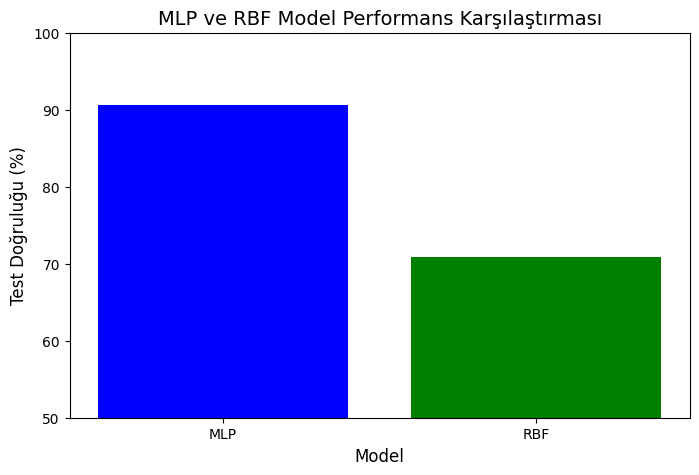

MLP modeli daha yüksek doğruluk sağladı (90.63%). Bu, daha küçük veri alt kümesinde ve az sayıda hiperparametre ile daha iyi performans göstermesini açıklayabilir.


In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Model sonuçları
mlp_accuracy = mlp_test_accuracy  # MLP model test doğruluğu
rbf_accuracy = test_accuracy  # RBF model test doğruluğu

# Sonuçları tabloya dökelim
results = {
    'Model': ['MLP', 'RBF'],
    'Test Accuracy': [mlp_accuracy * 100, rbf_accuracy * 100],  # Yüzde cinsinden doğruluk
}

df_results = pd.DataFrame(results)
print("Model Karşılaştırma Tablosu:")
print(df_results)

# Sonuçları görselleştirelim
plt.figure(figsize=(8, 5))

# Grafik: Test doğrulukları karşılaştırması
plt.bar(df_results['Model'], df_results['Test Accuracy'], color=['blue', 'green'])

# Başlık ve etiketler
plt.title('MLP ve RBF Model Performans Karşılaştırması', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Doğruluğu (%)', fontsize=12)
plt.ylim(50, 100)

# Göster
plt.show()

# Performans Yorumlama
if mlp_accuracy > rbf_accuracy:
    print(f"MLP modeli daha yüksek doğruluk sağladı ({mlp_accuracy * 100:.2f}%). Bu, daha küçük veri alt kümesinde ve az sayıda hiperparametre ile daha iyi performans göstermesini açıklayabilir.")
else:
    print(f"RBF modeli daha yüksek doğruluk sağladı ({rbf_accuracy * 100:.2f}%). Bu, modelin karmaşık verilere daha iyi uyum sağlamasıyla ilgili olabilir.")


- Yorum: MLP Modeli: %90.63 doğruluk ile daha iyi performans gösteriyor. Derin öğrenme yapısı ve uygun hiperparametreler sayesinde daha iyi sonuç aldı.
RBF Modeli: %70.91 doğruluk ile daha düşük performans gösteriyor. Hiperparametre ayarlarının iyileştirilmesi gerekebilir.
Sonuç: MLP, bu veri kümesi için daha iyi sonuç veriyor.